In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.Builder().appName(
    "big_data_project").config('spark.jars.packages','julioasotodv:spark-tree-plotting:0.2').getOrCreate()
spark

In [2]:
from PIL import Image
import io

In [3]:
from datetime import datetime, date
import pandas as pd
from pyspark.sql.functions import sum, min, max, avg, mean, count, countDistinct
from pyspark.sql.functions import round, col, percentile_approx
from pyspark import SparkContext
from pyspark.sql import SQLContext

from pyspark.sql import Row
df_csv = spark.read.csv('gs://dataproc-staging-na-northeast1-589316858355-djvptyy2/base_de_datos_coches.csv', header=True)
df_csv.show(2)

+----+----------+----+--------------------+---------+----------------+-----------------+----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
|Make|     Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|   Driven_Wheels|Number of Doors|     Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+----+----------+----+--------------------+---------+----------------+-----------------+----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
| BMW|1 Series M|2011|premium unleaded ...|      335|               6|           MANUAL|rear wheel drive|              2|Factory Tuner,Lux...|     Compact|        Coupe|         26|      19|      3916|46135|
| BMW|  1 Series|2011|premium unleaded ...|      300|               6|           MANUAL|rear wheel drive|              2|  Luxury,Performance|     Compact|  Convertible

### <span style="color:blue"> DATA EXPLORATION AND ANALYSIS </span>

In [129]:
df_csv.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: string (nullable = true)
 |-- Engine Cylinders: string (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: string (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: string (nullable = true)
 |-- city mpg: string (nullable = true)
 |-- Popularity: string (nullable = true)
 |-- MSRP: string (nullable = true)



### <span style="color:blue">Top 10 car makes with the highest sales </span>

In [5]:
df_csv.groupBy('Make').agg(
    round(sum('MSRP')/1000000, 2).alias('Total sales in Millions($)'), 
    count('Model').alias('Number of Cars'),
    percentile_approx('MSRP', 0.5).alias('Median Price'), 
    round(avg('MSRP'), 0).alias('Avg price for this make')
    ).orderBy('Total sales in Millions($)', ascending = False).show(10)

+-------------+--------------------------+--------------+------------+-----------------------+
|         Make|Total sales in Millions($)|Number of Cars|Median Price|Avg price for this make|
+-------------+--------------------------+--------------+------------+-----------------------+
|    Chevrolet|                     31.84|          1123|     26430.0|                28350.0|
|Mercedes-Benz|                     25.23|           353|     54500.0|                71476.0|
|         Ford|                     24.14|           881|     28540.0|                27399.0|
|   Volkswagen|                     22.73|           809|     27425.0|                28102.0|
|     Cadillac|                     22.32|           397|     51650.0|                56231.0|
|       Toyota|                     21.66|           746|     30160.0|                29030.0|
|          BMW|                     20.56|           334|     51700.0|                61547.0|
| Aston Martin|                     18.41|        

In [6]:
df_csv.registerTempTable('Cars')
sqlContext = SQLContext(spark)
df = sqlContext.sql("""
        SELECT Make, SUM(MSRP) as Total_sale,
        round(100*(SUM(MSRP))/SUM(SUM(MSRP)) OVER (), 2) as share_sales_percentage,
        SUM(SUM(MSRP)) OVER () as total_sale
        FROM cars
        GROUP BY Make
        order by share_sales_percentage desc
        """).toPandas()
df.head(10)

22/05/01 15:07:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/01 15:07:03 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/01 15:07:03 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/01 15:07:03 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,Make,Total_sale,share_sales_percentage,total_sale
0,Chevrolet,31837483.0,6.58,483645697.0
1,Mercedes-Benz,25231109.0,5.22,483645697.0
2,Ford,24138754.0,4.99,483645697.0
3,Volkswagen,22734826.0,4.70,483645697.0
4,Cadillac,22323833.0,4.62,483645697.0
5,Toyota,21656392.0,4.48,483645697.0
6,BMW,20556619.0,4.25,483645697.0
7,Aston Martin,18405665.0,3.81,483645697.0
8,Bentley,18290530.0,3.78,483645697.0
9,Audi,17532293.0,3.63,483645697.0


### <span style="color:blue">Luxury cars with the median price above $150K </span>

In [7]:
df_csv.groupBy('Make').agg(percentile_approx('MSRP', 0.5).alias('Median_Price')).orderBy('Median_Price', 
                                                               ascending = False).filter('Median_Price>150000').show()

+------------+------------+
|        Make|Median_Price|
+------------+------------+
|     Bugatti|   1705769.0|
|     Maybach|    423500.0|
| Rolls-Royce|    319400.0|
| Lamborghini|    251600.0|
|     McLaren|    239400.0|
|     Bentley|    231400.0|
|     Ferrari|    224585.0|
|      Spyker|    209990.0|
|Aston Martin|    195895.0|
+------------+------------+



### <span style="color:blue">Boxplots for famous German car makes </span>

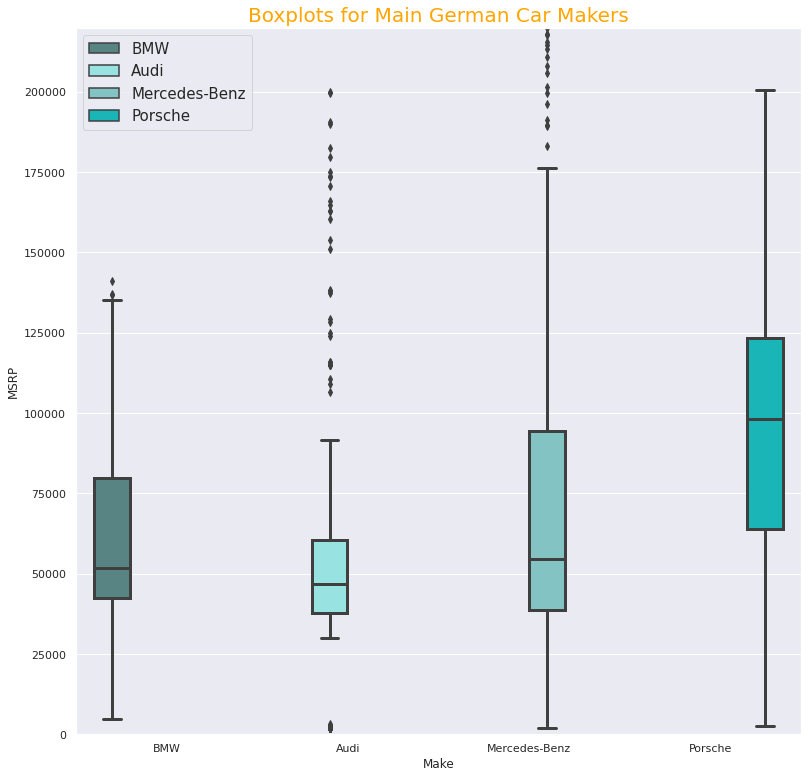

In [8]:
from pyspark.sql import SQLContext
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#Creating Table
df_new = df_csv.select('Make', 'MSRP', 'Engine HP')
exprs = [col(column).alias(column.replace(' ', '_')) for column in df_new.columns]
df_new = df_csv.select(*exprs)
df_new.registerTempTable('Cars')
sqlContext = SQLContext(spark)
#Running Query
df = sqlContext.sql("""select Make, MSRP, CAST(Engine_HP as int) horse_power
        from cars 
        where 
        Make == 'Audi' or make == 'BMW' or make == 'Mercedes-Benz' or make == 'Porsche'""").toPandas()

#Creating Visualization
sns.set_style("white")
sns.set(rc={'figure.figsize':(13, 13)})
my_pal = {"BMW": "#528B8B", "Audi" : "#8DEEEE",  "Mercedes-Benz" : "#79CDCD",  "Porsche" : '#00CED1'}
boxplot_gr = sns.boxplot(x = df['Make'],
            y = pd.to_numeric(df['MSRP']),
              hue = df['Make'],
           palette = my_pal,
           linewidth=3)
boxplot_gr.legend(fontsize=15)
plt.ylim(0, 220000)
plt.title('Boxplots for Main German Car Makers', fontsize=20, color = 'orange')
plt.show()

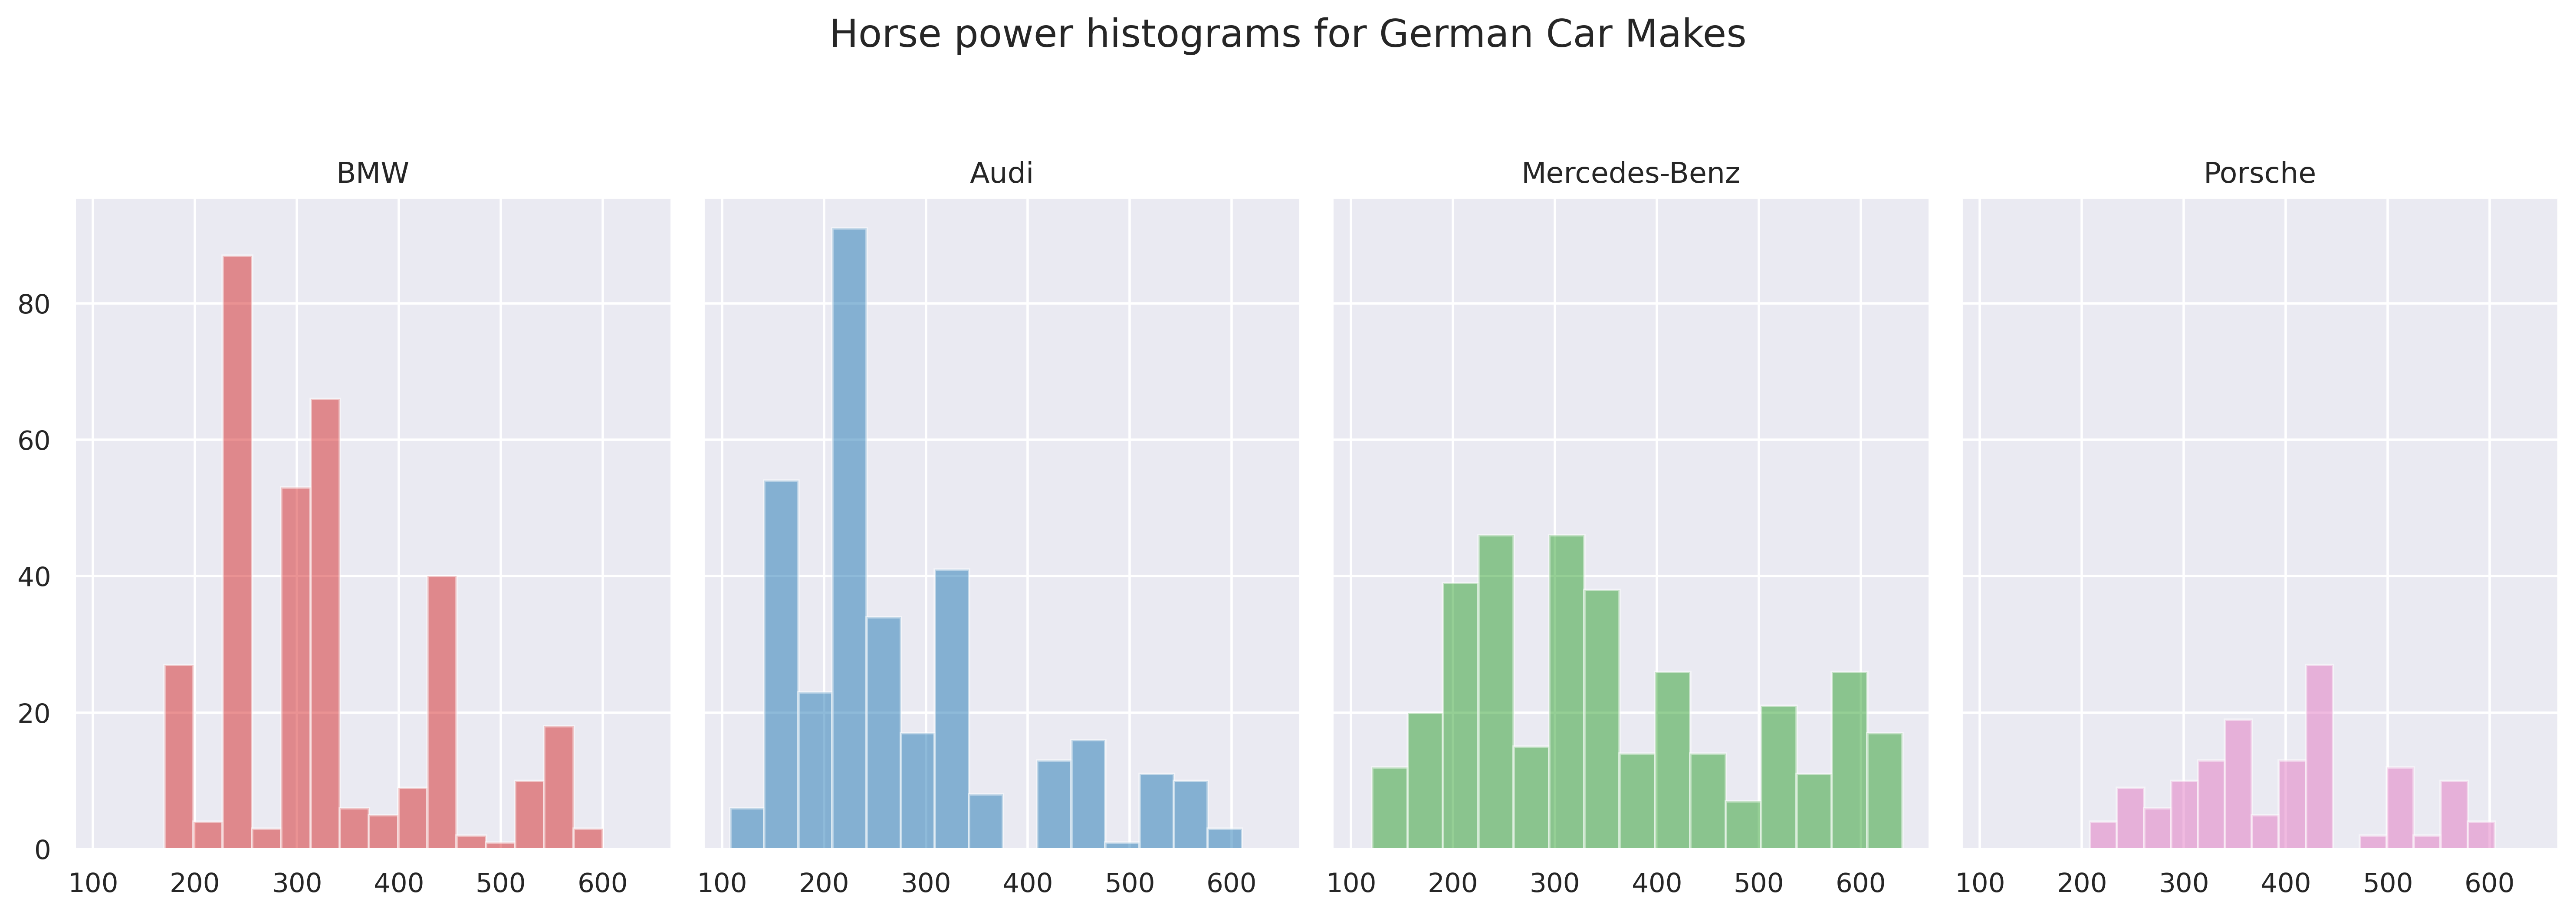

In [9]:
# Plot
fig, axes = plt.subplots(1, 4, figsize=(15, 5), dpi=400, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink']

for i, (ax, Make) in enumerate(zip(axes.flatten(), df.Make.unique())):
    x = df.loc[df.Make==Make, 'horse_power']
    ax.hist(x, alpha=0.5, bins=15, stacked=True, label=str(Make), color=colors[i])
    ax.set_title(Make)

plt.suptitle('Horse power histograms for German Car Makes', y=1.05, size=16)
plt.tight_layout();

In [19]:
exprs = [col(column).alias(column.replace(' ', '_')) for column in df_csv.columns]
print('There is strong positive correlation betwee horse power and the price of the cars and is equal to:')
df_csv.select(*exprs).selectExpr('float(Engine_HP) as horse_power', 'int(MSRP) as MSRP').stat.corr('horse_power', 'MSRP')



There is strong positive correlation betwee horse power and the price of the cars and is equal to:


0.6500953442373126

# <span style="color:blue">Supervised Learning </span>
## <span style="color:blue">Linear regression </span>

In [20]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, expr, when,\
desc, first, last, row_number, rank, substring
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.feature import StringIndexer


dfSupervisedLearning = df_csv
dfSupervisedLearning = dfSupervisedLearning.withColumn("Year",dfSupervisedLearning.Year.cast('double'))
dfSupervisedLearning = dfSupervisedLearning.withColumn("Engine HP",col("Engine HP").cast('double'))
dfSupervisedLearning = dfSupervisedLearning.withColumn("Engine Cylinders",col("Engine Cylinders").cast('double'))
dfSupervisedLearning = dfSupervisedLearning.withColumn("Number of Doors",col("Number of Doors").cast('double'))
dfSupervisedLearning = dfSupervisedLearning.withColumn("highway MPG",col("highway MPG").cast('double'))
dfSupervisedLearning = dfSupervisedLearning.withColumn("city mpg",col("city mpg").cast('double'))
dfSupervisedLearning = dfSupervisedLearning.withColumn("Popularity",col("Popularity").cast('double'))
dfSupervisedLearning = dfSupervisedLearning.withColumn("MSRP",col("MSRP").cast('double'))


#dfSupervisedLearning.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfSupervisedLearning.columns]
#   ).show()

dfSupervisedLearning = dfSupervisedLearning.na.drop(how="any")


#dfSupervisedLearning.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfSupervisedLearning.columns]
#   ).show()


indexer = StringIndexer(inputCol="Engine Fuel Type", outputCol="Engine Fuel Type Indexed")
dfIndexed = indexer.fit(dfSupervisedLearning).transform(dfSupervisedLearning)
dfIndexed = dfIndexed.drop("Engine Fuel Type")

indexer = StringIndexer(inputCol="Transmission Type", outputCol="Transmission Type Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Transmission Type")

indexer = StringIndexer(inputCol="Driven_Wheels", outputCol="Driven_Wheels Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Driven_Wheels")

indexer = StringIndexer(inputCol="Market Category", outputCol="Market Category Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Market Category")

indexer = StringIndexer(inputCol="Vehicle Size", outputCol="Vehicle Size Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Vehicle Size")

indexer = StringIndexer(inputCol="Vehicle Style", outputCol="Vehicle Style Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Vehicle Style")

dfIndexed.printSchema()




root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Engine HP: double (nullable = true)
 |-- Engine Cylinders: double (nullable = true)
 |-- Number of Doors: double (nullable = true)
 |-- highway MPG: double (nullable = true)
 |-- city mpg: double (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- MSRP: double (nullable = true)
 |-- Engine Fuel Type Indexed: double (nullable = false)
 |-- Transmission Type Indexed: double (nullable = false)
 |-- Driven_Wheels Indexed: double (nullable = false)
 |-- Market Category Indexed: double (nullable = false)
 |-- Vehicle Size Indexed: double (nullable = false)
 |-- Vehicle Style Indexed: double (nullable = false)



In [21]:
#Setting up Linear Regression for indexed dataset

vec_assembler = VectorAssembler(
    inputCols = ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity',
                'Engine Fuel Type Indexed', 'Transmission Type Indexed', 'Driven_Wheels Indexed', 
                'Market Category Indexed', 'Vehicle Size Indexed', 'Vehicle Style Indexed'],
    outputCol = 'inputFeatures')

features_df = vec_assembler.transform(dfIndexed)

model_df = features_df.select('inputFeatures','MSRP')

lr = LinearRegression(
    featuresCol='inputFeatures',
    labelCol='MSRP',
    regParam=0.001)

train_df, test_df = model_df.randomSplit(
    [0.7,0.3], seed = 777)


lr_model = lr.fit(train_df)


predictions = lr_model.evaluate(test_df)

print('R2:', predictions.r2, 
'MSE:', predictions.meanSquaredError,
'RMSE:', predictions.rootMeanSquaredError)


predictions = lr_model.transform(test_df)


predictions.withColumn(
    'residual', expr('MSRP - prediction')
).show(truncate=15)

R2: 0.5244474748036654 MSE: 1385080500.7765915 RMSE: 37216.66966262016
+---------------+-------+---------------+---------------+
|  inputFeatures|   MSRP|     prediction|       residual|
+---------------+-------+---------------+---------------+
|(13,[0,1,2,3...| 2000.0|-8070.283493...|10070.283493...|
|(13,[0,1,2,3...| 2000.0|19180.379708...|-17180.37970...|
|(13,[0,1,2,3...|15799.0|-322.3075650...|16121.307565...|
|(13,[0,1,2,3...|11820.0|-6555.204880...|18375.204880...|
|(13,[0,1,2,3...|15015.0|-14809.02293...|29824.022934...|
|(13,[0,1,2,3...|14315.0|-652.3153852...|14967.315385...|
|(13,[0,1,2,3...|11785.0|-422.5371811...|12207.537181...|
|(13,[0,1,2,3...|14349.0|9363.5844692...|4985.4155307...|
|(13,[0,1,2,3...|16049.0|9363.5844692...|6685.4155307...|
|(13,[0,1,2,3...|15599.0|-1124.010605...|16723.010605...|
|(13,[0,1,2,3...|16049.0|-1124.010605...|17173.010605...|
|(13,[0,1,2,3...|16995.0|4095.9052028...|12899.094797...|
|(13,[0,1,2,3...|15299.0|10039.806203...|5259.1937968...|
|

## <span style="color:blue">Logistic regression </span>

In [22]:
from pyspark.sql.functions import when
from pyspark.sql.functions import *

medVal = dfSupervisedLearning.agg(percentile_approx("MSRP", 0.5).alias("median"))

dfClass = dfSupervisedLearning.withColumn("class", \
   when((dfSupervisedLearning.MSRP < medVal.collect()[0][0]), lit(0)) \
     .when((dfSupervisedLearning.MSRP >= medVal.collect()[0][0]), lit(1)))
dfClass = dfClass.drop("MSRP")

#dfClass.groupBy("class").count().show()
#dfClass.printSchema()


#indexedDf with dummy categorical variables
medVal = dfIndexed.agg(percentile_approx("MSRP", 0.5).alias("median"))

dfClassIndexed = dfIndexed.withColumn("class", \
   when((dfIndexed.MSRP < medVal.collect()[0][0]), lit(0)) \
     .when((dfIndexed.MSRP >= medVal.collect()[0][0]), lit(1)))
dfClassIndexed = dfClassIndexed.drop("MSRP")

dfClassIndexed.groupBy("class").count().show()
dfClassIndexed.printSchema()

+-----+-----+
|class|count|
+-----+-----+
|    1| 5908|
|    0| 5904|
+-----+-----+

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Engine HP: double (nullable = true)
 |-- Engine Cylinders: double (nullable = true)
 |-- Number of Doors: double (nullable = true)
 |-- highway MPG: double (nullable = true)
 |-- city mpg: double (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Engine Fuel Type Indexed: double (nullable = false)
 |-- Transmission Type Indexed: double (nullable = false)
 |-- Driven_Wheels Indexed: double (nullable = false)
 |-- Market Category Indexed: double (nullable = false)
 |-- Vehicle Size Indexed: double (nullable = false)
 |-- Vehicle Style Indexed: double (nullable = false)
 |-- class: integer (nullable = true)



In [23]:
#Setting up logistic regression
from pyspark.ml.classification import LogisticRegression


vec_assembler = VectorAssembler(
    inputCols = ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity',
                'Engine Fuel Type Indexed', 'Transmission Type Indexed', 'Driven_Wheels Indexed', 
                'Market Category Indexed', 'Vehicle Size Indexed', 'Vehicle Style Indexed'],
    outputCol = 'features')

features_df = vec_assembler.transform(dfClassIndexed)

model_df = features_df.select('features','class')

train_df, test_df = model_df.randomSplit(
    [0.7,0.3], seed = 777)

log_reg = LogisticRegression(regParam=0.01, elasticNetParam=0,
    labelCol='class').fit(train_df)

train_results = log_reg.evaluate(train_df).predictions

test_results = log_reg.evaluate(test_df)
print("Accuracy of model:", test_results.accuracy)

predictions = test_results.predictions

print("Incorrect classification:", predictions.filter('class != prediction').count())
print("Correct classification:", predictions.filter('class == prediction').count())

from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report, confusion_matrix

predictionAndClass = predictions
predictionAndClass = predictionAndClass.drop('features', 'rawPrediction', 'probability')
predictionAndClass
y_true = predictionAndClass.select(['class']).collect()
y_pred = predictionAndClass.select(['prediction']).collect()

print(classification_report(y_true, y_pred))


22/05/01 15:11:37 ERROR breeze.optimize.LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed


Accuracy of model: 0.8753152143457551
Incorrect classification: 445
Correct classification: 3124
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1811
           1       0.88      0.86      0.87      1758

    accuracy                           0.88      3569
   macro avg       0.88      0.88      0.88      3569
weighted avg       0.88      0.88      0.88      3569



## <span style="color:blue">Naive Bayes </span>

In [24]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


vec_assembler = VectorAssembler(
    inputCols = ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity',
                'Engine Fuel Type Indexed', 'Transmission Type Indexed', 'Driven_Wheels Indexed', 
                'Market Category Indexed', 'Vehicle Size Indexed', 'Vehicle Style Indexed'],
    outputCol = 'features')

features_df = vec_assembler.transform(dfClassIndexed)


model_df = features_df.select('features','class')

train_df, test_df = model_df.randomSplit(
    [0.7,0.3], seed = 777)

nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol='features',labelCol = 'class').fit(train_df)

test_results = nb.transform(test_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction",
    metricName="accuracy")

accuracy = evaluator.evaluate(test_results)
print ("Model Accuracy for Naive Bayes (70:30 split): ", accuracy)

print('Count of right predictions', test_results.filter('class == prediction').count())
print('Count of wrong predictions', test_results.filter('class != prediction').count())




predictionAndClass = test_results
predictionAndClass = predictionAndClass.drop('features', 'rawPrediction', 'probability')
predictionAndClass
y_true = predictionAndClass.select(['class']).collect()
y_pred = predictionAndClass.select(['prediction']).collect()

print(classification_report(y_true, y_pred))

Model Accuracy for Naive Bayes (70:30 split):  0.8453348276828243


Count of right predictions 3017
Count of wrong predictions 552
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1811
           1       0.87      0.81      0.84      1758

    accuracy                           0.85      3569
   macro avg       0.85      0.84      0.84      3569
weighted avg       0.85      0.85      0.85      3569



# Part for Decision Tree, Random Forest,  Gradient Boost Tree

In [26]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, expr, when,\
desc, first, last, row_number, rank, substring
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.feature import StringIndexer


df_dt_class = df_csv
df_dt_class = df_dt_class.withColumn("Year",df_dt_class.Year.cast('double'))
df_dt_class = df_dt_class.withColumn("Engine HP",col("Engine HP").cast('double'))
df_dt_class = df_dt_class.withColumn("Engine Cylinders",col("Engine Cylinders").cast('double'))
df_dt_class = df_dt_class.withColumn("Number of Doors",col("Number of Doors").cast('double'))
df_dt_class = df_dt_class.withColumn("highway MPG",col("highway MPG").cast('double'))
df_dt_class = df_dt_class.withColumn("city mpg",col("city mpg").cast('double'))
df_dt_class = df_dt_class.withColumn("Popularity",col("Popularity").cast('double'))
df_dt_class = df_dt_class.withColumn("MSRP",col("MSRP").cast('double'))


#df_dt_class.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_dt_class.columns]
#   ).show()

df_dt_class = df_dt_class.na.drop(how="any")


#df_dt_class.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_dt_class.columns]
#   ).show()


indexer = StringIndexer(inputCol="Engine Fuel Type", outputCol="Engine Fuel Type Indexed")
dfIndexed = indexer.fit(df_dt_class).transform(df_dt_class)
dfIndexed = dfIndexed.drop("Engine Fuel Type")

indexer = StringIndexer(inputCol="Transmission Type", outputCol="Transmission Type Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Transmission Type")

indexer = StringIndexer(inputCol="Driven_Wheels", outputCol="Driven_Wheels Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Driven_Wheels")

indexer = StringIndexer(inputCol="Market Category", outputCol="Market Category Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Market Category")

indexer = StringIndexer(inputCol="Vehicle Size", outputCol="Vehicle Size Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Vehicle Size")

indexer = StringIndexer(inputCol="Vehicle Style", outputCol="Vehicle Style Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
dfIndexed = dfIndexed.drop("Vehicle Style")

indexer = StringIndexer(inputCol="Make", outputCol="Make_Indexed")
dfIndexed = indexer.fit(dfIndexed).transform(dfIndexed)
#dfIndexed = dfIndexed.drop("Make")

dfIndexed.show(3)


+----+----------+------+---------+----------------+---------------+-----------+--------+----------+-------+------------------------+-------------------------+---------------------+-----------------------+--------------------+---------------------+------------+
|Make|     Model|  Year|Engine HP|Engine Cylinders|Number of Doors|highway MPG|city mpg|Popularity|   MSRP|Engine Fuel Type Indexed|Transmission Type Indexed|Driven_Wheels Indexed|Market Category Indexed|Vehicle Size Indexed|Vehicle Style Indexed|Make_Indexed|
+----+----------+------+---------+----------------+---------------+-----------+--------+----------+-------+------------------------+-------------------------+---------------------+-----------------------+--------------------+---------------------+------------+
| BMW|1 Series M|2011.0|    335.0|             6.0|            2.0|       26.0|    19.0|    3916.0|46135.0|                     1.0|                      1.0|                  1.0|                   11.0|             

In [27]:
vec_assembler = VectorAssembler(
    inputCols = ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity','MSRP','Engine Fuel Type Indexed',"Transmission Type Indexed","Driven_Wheels Indexed","Market Category Indexed","Vehicle Size Indexed","Vehicle Style Indexed"],
    outputCol = 'inputFeatures')

features_df = vec_assembler.transform(dfIndexed)

In [28]:
model_df = features_df.select('inputFeatures','Make_Indexed',"Make")

## Decision Tree Classification Maker

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [30]:
df_dt_training, df_dt_test = model_df.randomSplit(
    [0.8, 0.2], seed = 5902)

(df_dt_training.count(), df_dt_test.count())

(9446, 2366)

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier
# Creating the model
dt_model = DecisionTreeClassifier(featuresCol = 'inputFeatures',
                                 labelCol = 'Make_Indexed',maxBins=71)

dt_train_results = dt_model.fit(df_dt_training)

In [32]:
# Features IMPORTANCE
dt_train_results.featureImportances.toArray()

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
dt_predictions_train = dt_train_results.transform(df_dt_training)

In [34]:
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(dt_predictions_train)
accuracy*100

58.69150963370738

In [35]:
dt_predictions_train.select("Make",'Make_Indexed', 
                   'prediction', 'probability').show()

+---------+------------+----------+--------------------+
|     Make|Make_Indexed|prediction|         probability|
+---------+------------+----------+--------------------+
|   Nissan|         5.0|       5.0|[0.0,0.0,0.0,0.0,...|
| Chrysler|        23.0|      23.0|[0.0,0.0,0.0,0.0,...|
|    Dodge|         4.0|       4.0|[0.0,0.0,0.0,0.0,...|
| Plymouth|        31.0|      11.0|[0.0,0.0,0.0,0.0,...|
| Chrysler|        23.0|      23.0|[0.0,0.0,0.0,0.0,...|
| Chrysler|        23.0|      23.0|[0.0,0.0,0.0,0.0,...|
| Plymouth|        31.0|      11.0|[0.0,0.0,0.0,0.0,...|
|    Dodge|         4.0|       4.0|[0.0,0.0,0.0,0.0,...|
|Chevrolet|         0.0|       0.0|[1.0,0.0,0.0,0.0,...|
|   Suzuki|        11.0|      11.0|[0.0,0.0,0.0,0.0,...|
|   Suzuki|        11.0|      11.0|[0.0,0.0,0.0,0.0,...|
|   Suzuki|        11.0|      11.0|[0.0,0.0,0.0,0.0,...|
|   Suzuki|        11.0|      11.0|[0.0,0.0,0.0,0.0,...|
|      Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|      Kia|        19.0|       

In [36]:
# Showing wrong predictions
dt_predictions_train.select("Make",'Make_Indexed', 
                   'prediction', 'probability').filter(
    'Make_Indexed != prediction').show()

+----------+------------+----------+--------------------+
|      Make|Make_Indexed|prediction|         probability|
+----------+------------+----------+--------------------+
|  Plymouth|        31.0|      11.0|[0.0,0.0,0.0,0.0,...|
|  Plymouth|        31.0|      11.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|Mitsubishi|  

In [37]:
dt_predictions_train.crosstab("Make_Indexed","prediction").show()

+-----------------------+---+---+----+----+---+----+---+---+---+---+---+---+
|Make_Indexed_prediction|0.0|1.0|11.0|15.0|2.0|23.0|3.0|4.0|5.0|6.0|7.0|9.0|
+-----------------------+---+---+----+----+---+----+---+---+---+---+---+---+
|                    0.0|906|  0|   0|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                    5.0|  0|  0|   0|   0|  0|   0|  0|  0|426|  0|  0|  0|
|                   10.0|  0|  0|   0|   0|  0|   0|  0|  0|  0|278|  0|  0|
|                   42.0|  0|  0|   3|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   24.0|  0|  0| 142|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   37.0|  0|  0|   0|   0|  0|  43|  0|  0|  0|  0|  0|  0|
|                   25.0|  0|  0| 128|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   14.0|  0|  0|   0|   0|  0|   0|  0|  0|  0|  0|261|  0|
|                   20.0|  0|  0| 171|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   46.0|  0|  0|   3|   0|  0|   0|  0|  0|  0|  0|  0|  0|

### Test

In [38]:
dt_predictions_test = dt_train_results.transform(df_dt_test)

# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(dt_predictions_test)
accuracy*100

57.396449704142015

In [39]:
dt_predictions_test.select("Make",'Make_Indexed', 
                   'prediction', 'probability').show()

+----------+------------+----------+--------------------+
|      Make|Make_Indexed|prediction|         probability|
+----------+------------+----------+--------------------+
|Oldsmobile|        26.0|      11.0|[0.0,0.0,0.0,0.0,...|
|Oldsmobile|        26.0|      11.0|[0.0,0.0,0.0,0.0,...|
|  Chrysler|        23.0|      23.0|[0.0,0.0,0.0,0.0,...|
|     Dodge|         4.0|       4.0|[0.0,0.0,0.0,0.0,...|
| Chevrolet|         0.0|       0.0|[1.0,0.0,0.0,0.0,...|
| Chevrolet|         0.0|       0.0|[1.0,0.0,0.0,0.0,...|
|    Suzuki|        11.0|      11.0|[0.0,0.0,0.0,0.0,...|
|      Ford|         1.0|       1.0|[0.0,1.0,0.0,0.0,...|
|    Suzuki|        11.0|      11.0|[0.0,0.0,0.0,0.0,...|
|    Suzuki|        11.0|      11.0|[0.0,0.0,0.0,0.0,...|
|    Nissan|         5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|    Toyota|         3.0|       3.0|[0.0,0.0,0.0,1.0,...|
|       Kia|        19.0|       9.0|[0.0,0.0,0.0,0.0,...|
|     Honda|         7.0|       7.0|[0.0,0.0,0.0,0.0,...|
|       Kia|  

In [40]:
dt_predictions_test.crosstab("Make_Indexed","prediction").show()

+-----------------------+---+---+----+----+---+----+---+---+---+---+---+---+
|Make_Indexed_prediction|0.0|1.0|11.0|15.0|2.0|23.0|3.0|4.0|5.0|6.0|7.0|9.0|
+-----------------------+---+---+----+----+---+----+---+---+---+---+---+---+
|                    0.0|209|  0|   0|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                    5.0|  0|  0|   0|   0|  0|   0|  0|  0|122|  0|  0|  0|
|                   10.0|  0|  0|   0|   0|  0|   0|  0|  0|  0| 74|  0|  0|
|                   42.0|  0|  0|   2|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   24.0|  0|  0|  44|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   37.0|  0|  0|   0|   0|  0|   9|  0|  0|  0|  0|  0|  0|
|                   25.0|  0|  0|  28|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   14.0|  0|  0|   0|   0|  0|   0|  0|  0|  0|  0| 67|  0|
|                   20.0|  0|  0|  39|   0|  0|   0|  0|  0|  0|  0|  0|  0|
|                   29.0|  0|  0|  23|   0|  0|   0|  0|  0|  0|  0|  0|  0|

In [41]:
print(dt_train_results.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_82a69caf73d4, depth=5, numNodes=23, numClasses=47, numFeatures=14
  If (feature 6 <= 4786.5)
   If (feature 6 <= 1785.5)
    If (feature 6 <= 1271.5)
     If (feature 6 <= 871.5)
      If (feature 6 <= 542.0)
       Predict: 11.0
      Else (feature 6 > 542.0)
       Predict: 6.0
     Else (feature 6 > 871.5)
      If (feature 6 <= 943.0)
       Predict: 2.0
      Else (feature 6 > 943.0)
       Predict: 23.0
    Else (feature 6 > 1271.5)
     If (feature 6 <= 1412.0)
      Predict: 0.0
     Else (feature 6 > 1412.0)
      If (feature 6 <= 1531.5)
       Predict: 15.0
      Else (feature 6 > 1531.5)
       Predict: 9.0
   Else (feature 6 > 1785.5)
    If (feature 6 <= 1930.0)
     Predict: 4.0
    Else (feature 6 > 1930.0)
     If (feature 6 <= 2020.0)
      Predict: 5.0
     Else (feature 6 > 2020.0)
      If (feature 6 <= 2116.5)
       Predict: 3.0
      Else (feature 6 > 2116.5)
       Predict: 7.0
  Else (feature 6 > 4786

In [42]:
def parse_debug_string_lines(lines):
    
    block = []
    while lines:


        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block


def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    

    return json

In [43]:
import json

dict_tree_json = debug_str_to_json(dt_train_results.toDebugString)

print(json.dumps(dict_tree_json,indent = 1 ))

{
 "name": "Root",
 "children": [
  {
   "name": "feature 6 <= 4786.5",
   "children": [
    {
     "name": "feature 6 <= 1785.5",
     "children": [
      {
       "name": "feature 6 <= 1271.5",
       "children": [
        {
         "name": "feature 6 <= 871.5",
         "children": [
          {
           "name": "feature 6 <= 542.0",
           "children": [
            {
             "name": "Predict: 11.0"
            }
           ]
          },
          {
           "name": "feature 6 > 542.0",
           "children": [
            {
             "name": "Predict: 6.0"
            }
           ]
          }
         ]
        },
        {
         "name": "feature 6 > 871.5",
         "children": [
          {
           "name": "feature 6 <= 943.0",
           "children": [
            {
             "name": "Predict: 2.0"
            }
           ]
          },
          {
           "name": "feature 6 > 943.0",
           "children": [
            {
             "name": "Pr

In [44]:
from IPython.core.display import HTML
HTML(''' <?xml version="1.0" standalone="no"?>
<svg xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" class="vtree" width="960" height="800"><style>
.vtree-node text { font: 14px sans-serif; }
.vtree-link { fill: none; stroke: #888; stroke-width: 2px; }
.vtree-table { stroke-width: 2px; stroke: steelblue; }
path.vtree-table { fill: white; }
g.vtree-node rect { fill: white; stroke: black; stroke-width: 1px; }
g.vtree-node rect.number-text { fill: #d8f0ed; }
g.vtree-node rect.string-text { fill: #e7f0db; }
g.vtree-node rect.boolean-text { fill: #e1d8f0; }
g.vtree-node rect.null-text { fill: #888; }
</style><g class="vtree-root" transform="translate(303.20787372757076,307.79015622520745)scale(0.4106553503760329)"><g class="vtree-node" transform="translate(480,106)"><g class="vtree-node" transform="translate(-42,0)"><path class="vtree-link" d="M42,12C42,59 -46,59 -46,106"/><g class="vtree-node" transform="translate(42,74)"><path class="vtree-link" d="M-88,32C-88,32 986,32 986,32"/><g class="vtree-node" transform="translate(-176,0)"><path class="vtree-link" d="M88,32C88,79 -277,79 -277,126"/><g class="vtree-node" transform="translate(88,94)"><path class="vtree-link" d="M-365,32C-365,32 620,32 620,32"/><g class="vtree-node" transform="translate(-453,0)"><path class="vtree-link" d="M88,32C88,79 -186,79 -186,126"/><g class="vtree-node" transform="translate(88,94)"><path class="vtree-link" d="M-274,32C-274,32 347,32 347,32"/><g class="vtree-node" transform="translate(-362,0)"><path class="vtree-link" d="M88,32C88,79 -85,79 -85,126"/><g class="vtree-node" transform="translate(88,94)"><path class="vtree-link" d="M-173,32C-173,32 174,32 174,32"/><g class="vtree-node" transform="translate(-257,0)"><path class="vtree-link" d="M84,32C84,79 -1,79 -1,126"/><g class="vtree-node" transform="translate(84,94)"><path class="vtree-link" d="M-85,32C-85,32 89,32 89,32"/><g class="vtree-node" transform="translate(-169,0)"><path class="vtree-link" d="M84,32C84,79 84,79 84,126"/><g class="vtree-node" transform="translate(84,94)"><g class="vtree-node" transform="translate(-65,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="86" height="24"/><text x="4" y="20">Predict: 11.0</text></g></g><g><text x="65" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="124" height="24"/><text x="4" y="20">feature 6 &lt;= 542.0</text></g></g><g><text x="84" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(9,0)"><path class="vtree-link" d="M80,32C80,79 80,79 80,126"/><g class="vtree-node" transform="translate(80,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 6.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="115" height="24"/><text x="4" y="20">feature 6 &gt; 542.0</text></g></g><g><text x="80" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="124" height="24"/><text x="4" y="20">feature 6 &lt;= 871.5</text></g></g><g><text x="84" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(94,0)"><path class="vtree-link" d="M80,32C80,79 -5,79 -5,126"/><g class="vtree-node" transform="translate(80,94)"><path class="vtree-link" d="M-85,32C-85,32 89,32 89,32"/><g class="vtree-node" transform="translate(-169,0)"><path class="vtree-link" d="M84,32C84,79 84,79 84,126"/><g class="vtree-node" transform="translate(84,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 2.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="124" height="24"/><text x="4" y="20">feature 6 &lt;= 943.0</text></g></g><g><text x="84" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(9,0)"><path class="vtree-link" d="M80,32C80,79 80,79 80,126"/><g class="vtree-node" transform="translate(80,94)"><g class="vtree-node" transform="translate(-66,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="87" height="24"/><text x="4" y="20">Predict: 23.0</text></g></g><g><text x="66" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="115" height="24"/><text x="4" y="20">feature 6 &gt; 943.0</text></g></g><g><text x="80" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="115" height="24"/><text x="4" y="20">feature 6 &gt; 871.5</text></g></g><g><text x="80" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="131" height="24"/><text x="4" y="20">feature 6 &lt;= 1271.5</text></g></g><g><text x="88" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(263,0)"><path class="vtree-link" d="M84,32C84,79 -97,79 -97,126"/><g class="vtree-node" transform="translate(84,94)"><path class="vtree-link" d="M-181,32C-181,32 92,32 92,32"/><g class="vtree-node" transform="translate(-269,0)"><path class="vtree-link" d="M88,32C88,79 88,79 88,126"/><g class="vtree-node" transform="translate(88,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 0.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="131" height="24"/><text x="4" y="20">feature 6 &lt;= 1412.0</text></g></g><g><text x="88" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(8,0)"><path class="vtree-link" d="M84,32C84,79 -4,79 -4,126"/><g class="vtree-node" transform="translate(84,94)"><path class="vtree-link" d="M-88,32C-88,32 93,32 93,32"/><g class="vtree-node" transform="translate(-176,0)"><path class="vtree-link" d="M88,32C88,79 88,79 88,126"/><g class="vtree-node" transform="translate(88,94)"><g class="vtree-node" transform="translate(-66,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="87" height="24"/><text x="4" y="20">Predict: 15.0</text></g></g><g><text x="66" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="131" height="24"/><text x="4" y="20">feature 6 &lt;= 1531.5</text></g></g><g><text x="88" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(9,0)"><path class="vtree-link" d="M84,32C84,79 84,79 84,126"/><g class="vtree-node" transform="translate(84,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 9.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="123" height="24"/><text x="4" y="20">feature 6 &gt; 1531.5</text></g></g><g><text x="84" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="123" height="24"/><text x="4" y="20">feature 6 &gt; 1412.0</text></g></g><g><text x="84" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="123" height="24"/><text x="4" y="20">feature 6 &gt; 1271.5</text></g></g><g><text x="84" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="131" height="24"/><text x="4" y="20">feature 6 &lt;= 1785.5</text></g></g><g><text x="88" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(536,0)"><path class="vtree-link" d="M84,32C84,79 -188,79 -188,126"/><g class="vtree-node" transform="translate(84,94)"><path class="vtree-link" d="M-272,32C-272,32 93,32 93,32"/><g class="vtree-node" transform="translate(-360,0)"><path class="vtree-link" d="M88,32C88,79 88,79 88,126"/><g class="vtree-node" transform="translate(88,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 4.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="131" height="24"/><text x="4" y="20">feature 6 &lt;= 1930.0</text></g></g><g><text x="88" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(9,0)"><path class="vtree-link" d="M84,32C84,79 -96,79 -96,126"/><g class="vtree-node" transform="translate(84,94)"><path class="vtree-link" d="M-180,32C-180,32 92,32 92,32"/><g class="vtree-node" transform="translate(-268,0)"><path class="vtree-link" d="M88,32C88,79 88,79 88,126"/><g class="vtree-node" transform="translate(88,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 5.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="131" height="24"/><text x="4" y="20">feature 6 &lt;= 2020.0</text></g></g><g><text x="88" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(8,0)"><path class="vtree-link" d="M84,32C84,79 -4,79 -4,126"/><g class="vtree-node" transform="translate(84,94)"><path class="vtree-link" d="M-88,32C-88,32 92,32 92,32"/><g class="vtree-node" transform="translate(-175,0)"><path class="vtree-link" d="M87,32C87,79 87,79 87,126"/><g class="vtree-node" transform="translate(87,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 3.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="130" height="24"/><text x="4" y="20">feature 6 &lt;= 2116.5</text></g></g><g><text x="87" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(9,0)"><path class="vtree-link" d="M83,32C83,79 83,79 83,126"/><g class="vtree-node" transform="translate(83,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 7.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="122" height="24"/><text x="4" y="20">feature 6 &gt; 2116.5</text></g></g><g><text x="83" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="123" height="24"/><text x="4" y="20">feature 6 &gt; 2020.0</text></g></g><g><text x="84" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="123" height="24"/><text x="4" y="20">feature 6 &gt; 1930.0</text></g></g><g><text x="84" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="123" height="24"/><text x="4" y="20">feature 6 &gt; 1785.5</text></g></g><g><text x="84" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="131" height="24"/><text x="4" y="20">feature 6 &lt;= 4786.5</text></g></g><g><text x="88" y="16" text-anchor="middle">children[0]</text></g></g><g class="vtree-node" transform="translate(902,0)"><path class="vtree-link" d="M84,32C84,79 84,79 84,126"/><g class="vtree-node" transform="translate(84,94)"><g class="vtree-node" transform="translate(-62,0)"><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="79" height="24"/><text x="4" y="20">Predict: 1.0</text></g></g><g><text x="62" y="16" text-anchor="middle">children[0]</text></g></g></g><g transform="translate(0,20)"><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="123" height="24"/><text x="4" y="20">feature 6 &gt; 4786.5</text></g></g><g><text x="84" y="16" text-anchor="middle">children[1]</text></g></g></g><g transform="translate(0,0)"><rect class="string-text" x="0" y="0" width="44" height="24"/><text x="4" y="20">name</text></g><g transform="translate(44,0)"><rect class="string-text" x="0" y="0" width="39" height="24"/><text x="4" y="20">Root</text></g></g></g></g></svg> ''')

## Random Forest

In [45]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import \
    IndexToString, StringIndexer, VectorIndexer

In [46]:
rf_model = RandomForestClassifier(featuresCol = 'inputFeatures',labelCol='Make_Indexed', numTrees=100,maxBins=71)

In [47]:
rf_train_results = rf_model.fit(df_dt_training)

22/05/01 15:14:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1711.6 KiB


In [48]:
rf_train_predictions = rf_train_results.transform(df_dt_training)

In [49]:
rf_train_predictions.select("Make",'Make_Indexed', 
                   'prediction', 'probability').show()

22/05/01 15:14:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+---------+------------+----------+--------------------+
|     Make|Make_Indexed|prediction|         probability|
+---------+------------+----------+--------------------+
|   Nissan|         5.0|       4.0|[0.10255657605751...|
| Chrysler|        23.0|       2.0|[0.10048090778776...|
|    Dodge|         4.0|       4.0|[0.10793896675235...|
| Plymouth|        31.0|      11.0|[0.08468678230087...|
| Chrysler|        23.0|       0.0|[0.09607284191513...|
| Chrysler|        23.0|       0.0|[0.09403791600962...|
| Plymouth|        31.0|      11.0|[0.08468678230087...|
|    Dodge|         4.0|       4.0|[0.10819750838879...|
|Chevrolet|         0.0|       0.0|[0.18738533767465...|
|   Suzuki|        11.0|      11.0|[0.07716607926934...|
|   Suzuki|        11.0|      11.0|[0.07716607926934...|
|   Suzuki|        11.0|      11.0|[0.07716607926934...|
|   Suzuki|        11.0|      11.0|[0.07716607926934...|
|      Kia|        19.0|       0.0|[0.13986261634501...|
|      Kia|        19.0|       

In [50]:
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(rf_train_predictions)
accuracy*100

22/05/01 15:14:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


64.13296633495659

In [53]:
rf_train_predictions.crosstab("Make_Indexed","prediction").show(5)

22/05/01 15:14:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+-----------------------+---+---+----+----+----+----+----+----+----+----+----+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+
|Make_Indexed_prediction|0.0|1.0|10.0|11.0|12.0|13.0|14.0|15.0|16.0|17.0|18.0|2.0|25.0|26.0|27.0|28.0|3.0|30.0|32.0|33.0|37.0|4.0|5.0|6.0|7.0|8.0|9.0|
+-----------------------+---+---+----+----+----+----+----+----+----+----+----+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+
|                    0.0|892|  0|   0|   0|   0|   0|   0|   0|   0|   0|   0| 14|   0|   0|   0|   0|  0|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|
|                    5.0| 63|  0|   0|   0|   0|   0|   5|   0|   0|   0|   0| 31|   0|   0|   0|   0| 23|   0|   0|   0|   0| 32|269|  0|  0|  0|  3|
|                   10.0| 12|  0| 243|   0|   0|   0|   2|   0|   7|   0|   0| 14|   0|   0|   0|   0|  0|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|
|                   42.0|  0|  0|   0|   0|   0|   0|   3|   0|   0|   0|   0|  0|   0|   0|  

22/05/01 15:14:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/05/01 15:14:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [54]:
rf_trainResults = rf_train_predictions.crosstab("Make_Indexed","prediction")

22/05/01 15:14:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/01 15:14:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/05/01 15:14:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [55]:
rf_trainResults.show(5)

+-----------------------+---+---+----+----+----+----+----+----+----+----+----+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+
|Make_Indexed_prediction|0.0|1.0|10.0|11.0|12.0|13.0|14.0|15.0|16.0|17.0|18.0|2.0|25.0|26.0|27.0|28.0|3.0|30.0|32.0|33.0|37.0|4.0|5.0|6.0|7.0|8.0|9.0|
+-----------------------+---+---+----+----+----+----+----+----+----+----+----+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+
|                    0.0|892|  0|   0|   0|   0|   0|   0|   0|   0|   0|   0| 14|   0|   0|   0|   0|  0|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|
|                    5.0| 63|  0|   0|   0|   0|   0|   5|   0|   0|   0|   0| 31|   0|   0|   0|   0| 23|   0|   0|   0|   0| 32|269|  0|  0|  0|  3|
|                   10.0| 12|  0| 243|   0|   0|   0|   2|   0|   7|   0|   0| 14|   0|   0|   0|   0|  0|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|
|                   42.0|  0|  0|   0|   0|   0|   0|   3|   0|   0|   0|   0|  0|   0|   0|  

#### Test

In [56]:
rf_test_predictions = rf_train_results.transform(df_dt_test)

rf_test_predictions.select("Make",'Make_Indexed', 
                   'prediction', 'probability').show()

22/05/01 15:14:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+----------+------------+----------+--------------------+
|      Make|Make_Indexed|prediction|         probability|
+----------+------------+----------+--------------------+
|Oldsmobile|        26.0|      11.0|[0.07370656940364...|
|Oldsmobile|        26.0|      11.0|[0.07370656940364...|
|  Chrysler|        23.0|       0.0|[0.09403791600962...|
|     Dodge|         4.0|       4.0|[0.10819750838879...|
| Chevrolet|         0.0|       0.0|[0.17547845465456...|
| Chevrolet|         0.0|       0.0|[0.17750736555667...|
|    Suzuki|        11.0|      11.0|[0.07716607926934...|
|      Ford|         1.0|       1.0|[0.03167210995969...|
|    Suzuki|        11.0|      11.0|[0.07782080317898...|
|    Suzuki|        11.0|       2.0|[0.08271895051294...|
|    Nissan|         5.0|       5.0|[0.12514169984518...|
|    Toyota|         3.0|       3.0|[0.07273632721689...|
|       Kia|        19.0|       0.0|[0.14529716975022...|
|     Honda|         7.0|       7.0|[0.05737410010290...|
|       Kia|  

In [57]:
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(rf_test_predictions)
accuracy*100

22/05/01 15:14:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


65.17328825021133

In [59]:
rf_testResults = rf_test_predictions.crosstab("Make_Indexed","prediction")
rf_testResults.show(5)

22/05/01 15:14:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/01 15:14:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+-----------------------+---+---+----+----+----+----+----+----+----+----+----+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+
|Make_Indexed_prediction|0.0|1.0|10.0|11.0|12.0|13.0|14.0|15.0|16.0|17.0|18.0|2.0|25.0|26.0|27.0|28.0|3.0|30.0|32.0|33.0|37.0|4.0|5.0|6.0|7.0|8.0|9.0|
+-----------------------+---+---+----+----+----+----+----+----+----+----+----+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+
|                    0.0|204|  0|   0|   0|   0|   0|   0|   0|   0|   0|   0|  5|   0|   0|   0|   0|  0|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|
|                    5.0| 16|  0|   0|   0|   0|   0|   0|   0|   0|   0|   0|  8|   0|   0|   0|   0| 10|   0|   0|   0|   0|  9| 77|  0|  0|  0|  2|
|                   10.0|  3|  0|  66|   0|   0|   0|   0|   0|   2|   0|   0|  3|   0|   0|   0|   0|  0|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|
|                   42.0|  0|  0|   0|   0|   0|   0|   2|   0|   0|   0|   0|  0|   0|   0|  

22/05/01 15:14:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


## Gradient Tree Boosting

In [60]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

model_df.groupBy("Make").count().sort("count",ascending=False).show()

+-------------+-----+
|         Make|count|
+-------------+-----+
|    Chevrolet| 1115|
|         Ford|  868|
|   Volkswagen|  805|
|       Toyota|  743|
|        Dodge|  626|
|       Nissan|  548|
|          GMC|  515|
|        Honda|  447|
|        Mazda|  403|
|     Cadillac|  397|
|Mercedes-Benz|  352|
|       Suzuki|  348|
|          BMW|  334|
|     Infiniti|  330|
|         Audi|  328|
|      Hyundai|  303|
|        Volvo|  281|
|       Subaru|  256|
|        Acura|  252|
|          Kia|  226|
+-------------+-----+
only showing top 20 rows



##### We'll try to differentiate the two biggest american car makers

In [61]:
df_2_Biggest_Car_Makers = model_df.filter((model_df.Make == "Chevrolet") | (model_df.Make == "Ford"))
df_2_Biggest_Car_Makers.groupBy("Make").count().show()

+---------+-----+
|     Make|count|
+---------+-----+
|Chevrolet| 1115|
|     Ford|  868|
+---------+-----+



In [62]:
# Train a GBT model

gbt = GBTClassifier(
    featuresCol = 'inputFeatures',labelCol='Make_Indexed',
    maxDepth=15,
    maxIter=30,maxBins=71)

In [63]:
df_gtb_training, df_gtb_test = df_2_Biggest_Car_Makers.randomSplit(
    [0.8, 0.2], seed = 5902)

(df_gtb_training.count(), df_gtb_test.count())

(1573, 410)

In [64]:
gbt_model = gbt.fit(df_gtb_training)
gbt_train_predictions = gbt_model.transform(df_gtb_training)

In [65]:
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(gbt_train_predictions)
accuracy*100

100.0

In [66]:
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(gbt_train_predictions)
accuracy*100

100.0

#### Test

In [67]:
gbt_test_predictions = gbt_model.transform(df_gtb_test)
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(gbt_test_predictions)
accuracy*100

100.0

In [68]:
gbt_train_predictions.crosstab("Make_Indexed","prediction").show()

+-----------------------+---+---+
|Make_Indexed_prediction|0.0|1.0|
+-----------------------+---+---+
|                    1.0|  0|701|
|                    0.0|872|  0|
+-----------------------+---+---+



In [69]:
df_2_Biggest_Car_Makers_NoUs = model_df.filter((model_df.Make == "Volkswagen") | (model_df.Make == "Toyota"))
df_2_Biggest_Car_Makers_NoUs.groupBy("Make").count().show()

+----------+-----+
|      Make|count|
+----------+-----+
|Volkswagen|  805|
|    Toyota|  743|
+----------+-----+



In [70]:
df_2_Biggest_Car_Makers_NoUs.filter(df_2_Biggest_Car_Makers_NoUs.Make =="Toyota").select("Make","Make_Indexed").show()

+------+------------+
|  Make|Make_Indexed|
+------+------------+
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
|Toyota|         3.0|
+------+------------+
only showing top 20 rows



In [72]:
df_2_Biggest_Car_Makers_NoUs.filter(df_2_Biggest_Car_Makers_NoUs.Make =="Volkswagen").select("Make","Make_Indexed").show()

+----------+------------+
|      Make|Make_Indexed|
+----------+------------+
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
|Volkswagen|         2.0|
+----------+------------+
only showing top 20 rows



In [73]:
df_2_Biggest_Car_Makers_NoUs=df_2_Biggest_Car_Makers_NoUs.withColumn("Make_Indexed",col("Make_Indexed")-2)

In [74]:
df_2_Biggest_Car_Makers_NoUs.filter(df_2_Biggest_Car_Makers_NoUs.Make =="Volkswagen").select("Make","Make_Indexed").show()

+----------+------------+
|      Make|Make_Indexed|
+----------+------------+
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
|Volkswagen|         0.0|
+----------+------------+
only showing top 20 rows



In [75]:
# Train a GBT model

gbt2 = GBTClassifier(
    featuresCol = 'inputFeatures',labelCol='Make_Indexed',
    maxDepth=15,
    maxIter=30,maxBins=71)

In [76]:
df_gtb_training2, df_gtb_test2 = df_2_Biggest_Car_Makers_NoUs.randomSplit(
    [0.8, 0.2], seed = 5902)

(df_gtb_training2.count(), df_gtb_test2.count())

(1232, 316)

In [77]:
gbt_model2 = gbt2.fit(df_gtb_training2)
gbt_train_predictions2 = gbt_model2.transform(df_gtb_training2)

In [78]:
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(gbt_train_predictions2)
accuracy*100

100.0

In [79]:
gbt_test_predictions2 = gbt_model2.transform(df_gtb_test2)

In [80]:
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="Make_Indexed", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(gbt_test_predictions2)
accuracy*100

100.0

In [81]:
gbt_test_predictions2.crosstab("Make_Indexed","prediction").show()

+-----------------------+---+---+
|Make_Indexed_prediction|0.0|1.0|
+-----------------------+---+---+
|                    1.0|  0|161|
|                    0.0|155|  0|
+-----------------------+---+---+



# K-means models

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler

In [83]:
vecAssembler = VectorAssembler(inputCols=['Year', 'Engine HP', 'Engine Cylinders', 
                                          'Number of Doors', 'highway MPG', 'city mpg',
                                          'Popularity','MSRP',
                                          'Engine Fuel Type Indexed',
                                          "Transmission Type Indexed",
                                          "Driven_Wheels Indexed",
                                          "Market Category Indexed",
                                          "Vehicle Size Indexed",
                                          "Vehicle Style Indexed"], 
                               outputCol='features')
kmeans = KMeans(k = 3, seed = 777)
pipeline = Pipeline(stages = [vecAssembler, kmeans])
pipeline_model = pipeline.fit(features_df)
centers = pipeline_model.stages[-1].clusterCenters()
centers

[array([2.01029108e+03, 2.38007658e+02, 5.47249362e+00, 3.47055717e+00,
        2.66214242e+01, 1.96131503e+01, 1.57380081e+03, 3.17869680e+04,
        7.30569492e-01, 3.45744213e-01, 1.02112490e+00, 5.73629082e+00,
        8.30824751e-01, 3.31889798e+00]),
 array([2.01217528e+03, 5.35391011e+02, 1.00539326e+01, 2.47191011e+00,
        1.88067416e+01, 1.21932584e+01, 1.05250337e+03, 2.43657960e+05,
        1.26966292e+00, 7.93258427e-01, 1.37303371e+00, 1.84112360e+01,
        9.19101124e-01, 1.87865169e+00]),
 array([2.00933333e+03, 8.15500000e+02, 1.40000000e+01, 2.66666667e+00,
        1.46666667e+01, 8.83333333e+00, 6.25333333e+02, 1.58907017e+06,
        1.00000000e+00, 1.33333333e+00, 1.66666667e+00, 1.43333333e+01,
        6.66666667e-01, 2.33333333e+00])]

In [99]:
features_df.show(3)

+----+----------+------+---------+----------------+---------------+-----------+--------+----------+-------+------------------------+-------------------------+---------------------+-----------------------+--------------------+---------------------+------------+--------------------+
|Make|     Model|  Year|Engine HP|Engine Cylinders|Number of Doors|highway MPG|city mpg|Popularity|   MSRP|Engine Fuel Type Indexed|Transmission Type Indexed|Driven_Wheels Indexed|Market Category Indexed|Vehicle Size Indexed|Vehicle Style Indexed|Make_Indexed|       inputFeatures|
+----+----------+------+---------+----------------+---------------+-----------+--------+----------+-------+------------------------+-------------------------+---------------------+-----------------------+--------------------+---------------------+------------+--------------------+
| BMW|1 Series M|2011.0|    335.0|             6.0|            2.0|       26.0|    19.0|    3916.0|46135.0|                     1.0|                      

# silhoutte coeff

In [86]:
predictions = pipeline_model.transform(features_df)
predictions.groupBy(
    'prediction').count().orderBy(
    'prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|11361|
|         1|  445|
|         2|    6|
+----------+-----+



In [87]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance =",str(silhouette))

Silhouette with squared euclidean distance = 0.9623571160236818


# visualization

In [88]:
pandasDF = predictions.select('Year', 'Engine HP', 'Engine Cylinders', 
                              'Number of Doors', 'highway MPG', 'city mpg',
                              'Popularity','MSRP',
                              'Engine Fuel Type Indexed',
                              "Transmission Type Indexed",
                              "Driven_Wheels Indexed",
                              "Market Category Indexed",
                              "Vehicle Size Indexed",
                              "Vehicle Style Indexed",'prediction').toPandas()

pandasDF.head(5)

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP,Engine Fuel Type Indexed,Transmission Type Indexed,Driven_Wheels Indexed,Market Category Indexed,Vehicle Size Indexed,Vehicle Style Indexed,prediction
0,2011.0,335.0,6.0,2.0,26.0,19.0,3916.0,46135.0,1.0,1.0,1.0,11.0,0.0,2.0,0
1,2011.0,300.0,6.0,2.0,28.0,19.0,3916.0,40650.0,1.0,1.0,1.0,4.0,0.0,3.0,0
2,2011.0,300.0,6.0,2.0,28.0,20.0,3916.0,36350.0,1.0,1.0,1.0,8.0,0.0,2.0,0
3,2011.0,230.0,6.0,2.0,28.0,18.0,3916.0,29450.0,1.0,1.0,1.0,4.0,0.0,2.0,0
4,2011.0,230.0,6.0,2.0,28.0,18.0,3916.0,34500.0,1.0,1.0,1.0,3.0,0.0,3.0,0


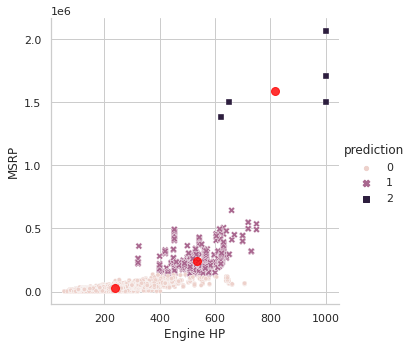

In [90]:
sns.relplot(x="Engine HP", y="MSRP", hue="prediction", 
            style="prediction", 
            size="prediction",
            data=pandasDF);

plt.scatter([c[1] for c in centers], 
            [c[7] for c in centers], 
            c='red', s=64, alpha=0.8);

# PCA for dimension reduction

In [91]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg  import Vectors
from pyspark.ml.functions import vector_to_array

In [120]:
model_df.registerTempTable('model_df')
df = sqlContext.sql("""select *
        from model_df 
        where 
        Make == 'Audi' or Make == 'Porsche' or Make == 'Volkswagen'""")
df.show(5)

+--------------------+------------+----+
|       inputFeatures|Make_Indexed|Make|
+--------------------+------------+----+
|[1992.0,172.0,6.0...|        14.0|Audi|
|[1992.0,172.0,6.0...|        14.0|Audi|
|[1992.0,172.0,6.0...|        14.0|Audi|
|[1992.0,172.0,6.0...|        14.0|Audi|
|[1992.0,172.0,6.0...|        14.0|Audi|
+--------------------+------------+----+
only showing top 5 rows



###### PCA is used here to go from high dimensional data to low. PCA is good in our model as it might reduce the number of independent variable to work with.

##### The first model has k = 3 number of components that we desire to see in the final output

In [121]:
scaler = StandardScaler(inputCol="inputFeatures", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures") #k is responsible here for the desired number of variables in final output
pipeline = Pipeline(stages = [scaler, pca])
model_1 = pipeline.fit(df)
scaledDF = model_1.transform(df).select('pcaFeatures', 'Make')
scaledDF.show(5, truncate=False)

+------------------------------------------------------------+----+
|pcaFeatures                                                 |Make|
+------------------------------------------------------------+----+
|[-0.719035040030388,-2.4237249176539284,2.3392415863344103] |Audi|
|[-0.719035040030388,-2.4237249176539284,2.3392415863344103] |Audi|
|[-1.3398992025374572,-3.3419524616964336,1.8662559918527832]|Audi|
|[-0.719035040030388,-2.4237249176539284,2.3392415863344103] |Audi|
|[-1.7183658141816678,-2.43172777786835,2.3664775232138435]  |Audi|
+------------------------------------------------------------+----+
only showing top 5 rows



In [122]:
model_1.stages[-1].explainedVariance.sum()

0.6058723721975503

##### The second model has k = 5 number of components that we desire to see in the final output

In [123]:
scaler = StandardScaler(inputCol="inputFeatures", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
pca = PCA(k = 5, inputCol="scaledFeatures", outputCol="pcaFeatures") #k is responsible here for the desired number of variables in final output
pipeline = Pipeline(stages = [scaler, pca])
model_2 = pipeline.fit(df)
scaledDF = model_2.transform(df).select('pcaFeatures', 'Make')
scaledDF.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------+----+
|pcaFeatures                                                                                      |Make|
+-------------------------------------------------------------------------------------------------+----+
|[-0.719035040030388,-2.4237249176539284,2.3392415863344103,-1.3075089748609252,2.273540493715606]|Audi|
|[-0.719035040030388,-2.4237249176539284,2.3392415863344103,-1.3075089748609252,2.273540493715606]|Audi|
|[-1.3398992025374572,-3.3419524616964336,1.8662559918527832,-2.36069660061017,0.9575983232218006]|Audi|
|[-0.719035040030388,-2.4237249176539284,2.3392415863344103,-1.3075089748609252,2.273540493715606]|Audi|
|[-1.7183658141816678,-2.43172777786835,2.3664775232138435,-1.7528686152495871,2.44258448190184]  |Audi|
+-------------------------------------------------------------------------------------------------+----+
only showing top 5 rows



In [124]:
model_2.stages[-1].explainedVariance.sum()

0.7562987603092939

#### As it's seen, the more number of components we choose, the more variance of initial variables is covered. When we go from 3 number of components to 5, the more variance of initial parameters is covered.

In [125]:
pcaDF = scaledDF.withColumn(
    'PC1', vector_to_array('pcaFeatures')[0]
).withColumn(
    'PC2', vector_to_array('pcaFeatures')[1]
).withColumn(
    'PC3', vector_to_array('pcaFeatures')[2]
).select('PC1', 'PC2', 'PC3', 'Make')
pcaDF.show(5)

+-------------------+-------------------+------------------+----+
|                PC1|                PC2|               PC3|Make|
+-------------------+-------------------+------------------+----+
| -0.719035040030388|-2.4237249176539284|2.3392415863344103|Audi|
| -0.719035040030388|-2.4237249176539284|2.3392415863344103|Audi|
|-1.3398992025374572|-3.3419524616964336|1.8662559918527832|Audi|
| -0.719035040030388|-2.4237249176539284|2.3392415863344103|Audi|
|-1.7183658141816678|  -2.43172777786835|2.3664775232138435|Audi|
+-------------------+-------------------+------------------+----+
only showing top 5 rows



In [126]:
pandasDF = pcaDF.toPandas()
pandasDF.head(5)

,PC1,PC2,PC3,Make
0,-0.719035,-2.423725,2.339242,Audi
1,-0.719035,-2.423725,2.339242,Audi
2,-1.339899,-3.341952,1.866256,Audi
3,-0.719035,-2.423725,2.339242,Audi
4,-1.718366,-2.431728,2.366478,Audi


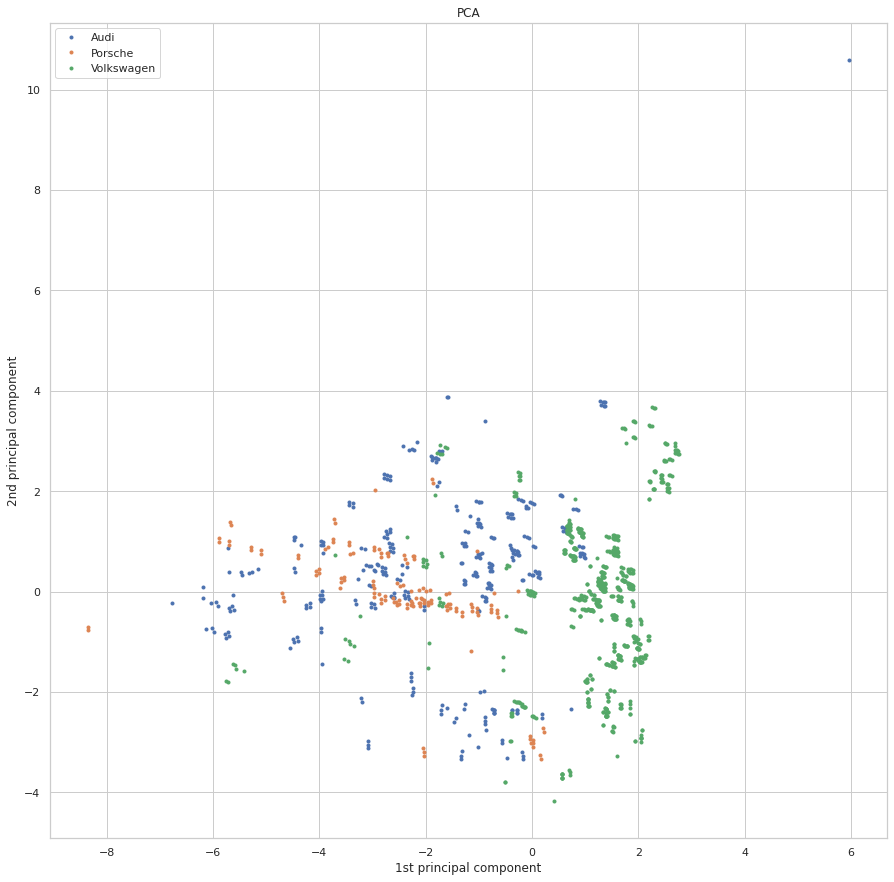

In [127]:
fig, ax = plt.subplots(figsize=(15,15))          
groups = pandasDF.groupby('Make')
for name, group in groups:
    ax.plot(group['PC1'], group['PC2'], marker='o', 
             linestyle='', markersize=3, label=name)
ax.set_title('PCA')
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
plt.legend()

In [128]:
sc.stop()